# 🏨 **Hotel Cancel Culture - Time Series Modeling & Forecasting**

---

**Forecasting Cancellations**

> * **Goal:** Forecast cancellations for the given hotel data
> * **Why:** Predictions only work on preexisting reservations
    * *How can we forecast occupancy without depending on preexisting reservations?*
> * **How:** Using probabilities generated from prior classification modeling to forecast future cancellations

---

# **Imports**

In [1]:
## JNB tool to reload functions when called
%load_ext autoreload
%autoreload 2

In [2]:
## Enabling access to custom functions in separate directory

# Import necessary modules
import os
import sys

# Construct the absolute path to the 'src' directory
src_path = os.path.abspath(os.path.join('../..', 'src'))

# Append the path to 'sys.path'
if src_path not in sys.path:
    sys.path.append(src_path)

# import db_utils, eda
import time_series_modeling as tsm

In [3]:
## Data Handling
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pmd
from pmdarima.arima import AutoARIMA
from pmdarima.preprocessing import BoxCoxEndogTransformer, FourierFeaturizer
from pmdarima.pipeline import Pipeline
import statsmodels.tsa.api as tsa

# **Reading Data**

---

**Reading Data and Setting the Datetime Index**

> I will import the data I cleaned and prepped in advance for my modeling processes.
>
> I created an `arrival_date` column during the prep process containing the arrival date as a datetime object. Using this feature, I will reset my index to enable the time series modeling.

---

In [4]:
with open('../../data/column_groups.json') as file:
    col_dict = json.load(file)

col_dict.keys()

dict_keys(['booking_details', 'post_stay_details', 'reservation_specific', 'temporal_features', 'new_temporal_features'])

In [5]:
# booking_cols = col_dict['booking_details']
# temporal_cols = col_dict['new_temporal_features']

# booking_cols.extend(temporal_cols)
# usecols = set(booking_cols)
# usecols

In [6]:
## Reading data and setting DT index
path = '../../data/2.2_temporally_updated_data.feather'
data = pd.read_feather(path, columns = ['ADR', 'ArrivalDate'])
data = data.sort_values('ArrivalDate')
data = data.set_index('ArrivalDate')
data

,ADR
ArrivalDate,
2015-07-01,0.00
2015-07-01,80.00
2015-07-01,134.00
2015-07-01,101.50
2015-07-01,101.50
...,...
2017-08-31,86.85
2017-08-31,162.50
2017-08-31,129.00


# **Resampling**

---

**Resampling the Arrival Dates**

> My dataset includes multiple reservations per day, which makes sense, but also impairs the modeling process.
>
> **I will resample the data as daily averages for the modeling and forecasting process.**
* *Daily resampling* allows me to view the data for all reservations for a given day.
* *Computing the average cancellations* provides a normalized value allowing for easy comparisons between dates (without having to consider other features, such as occupancy, demand, etc.).

ArrivalDate
2015-07-03     90.739151
2015-07-04     88.323597
2015-07-05     94.255983
2015-07-06     92.014660
2015-07-07     94.347051
                 ...    
2017-08-27    158.251391
2017-08-28    157.970288
2017-08-29    149.662944
2017-08-30    148.826133
2017-08-31    148.604452
Freq: D, Name: ADR, Length: 791, dtype: float64

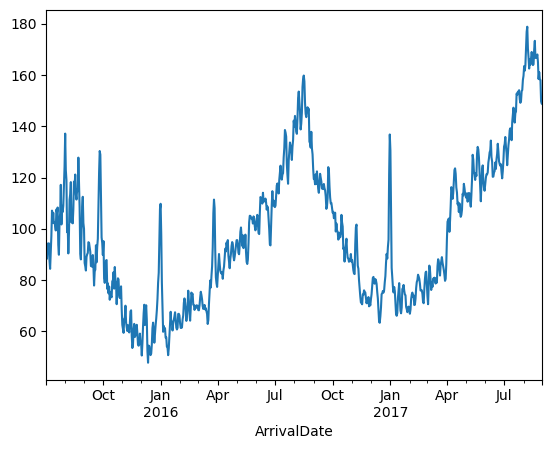

In [122]:
## Resampling for average daily cancellations
ts_avg = data['ADR'].resample('D').mean().rolling(window=3).mean().dropna()
display(ts_avg)
ts_avg.plot();

In [123]:
# ## Subsetting data from 2016-17
# ts_avg = ts_avg.loc[:'2016-12-31']
# ts_avg

# Train/Test Split

---

I will split my data to reserve the last 90 days-worth of data for testing. In my experience, we usually focus on a short-term window for forecasting due to the increasing volatility as time goes on.

Ideally, I would prefer to forecast for an entire year, but due to the short timeline of my source data, I would have little data to use to train the model.

---

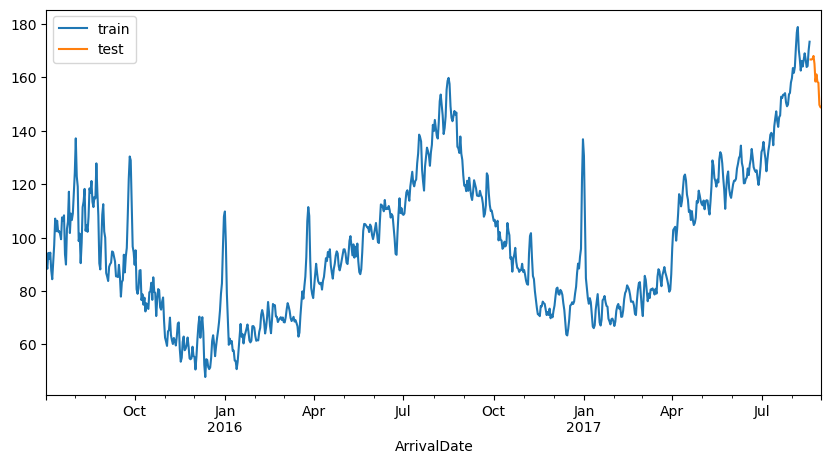

In [124]:
train, test = pmd.model_selection.train_test_split(ts_avg, test_size = 12)
fig, ax = plt.subplots(figsize=(10,5))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
ax.legend();

# **Seasonal Decomposition**

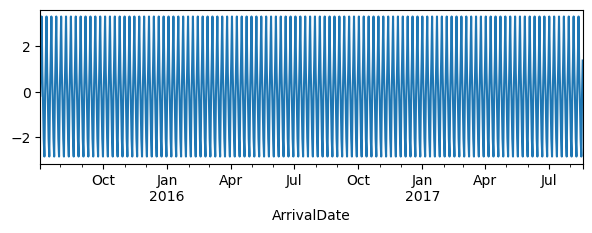

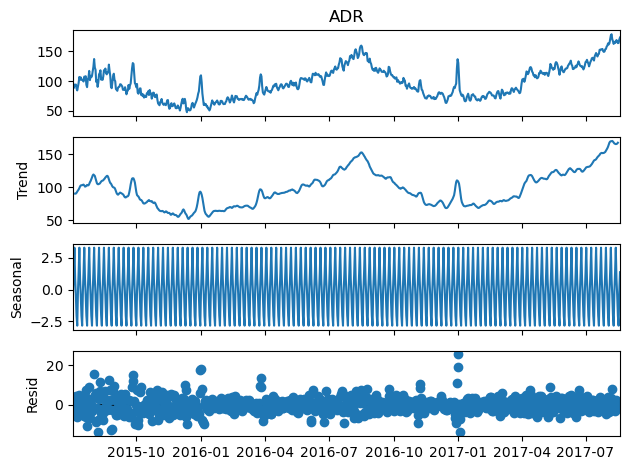

In [125]:
## Performing seasonal decomp to determine seasonality for modeling
# decomp = tsa.seasonal_decompose(split_dict['train'].loc['01-2016':'06-2016'])
decomp = tsa.seasonal_decompose(train, period = 7)
decomp.seasonal.plot(figsize = (7,2));
decomp.plot();

In [126]:
## Examining smaller slice to determine seasonality
# decomp = tsa.seasonal_decompose(split_dict['train'].loc['01-2016':'02-2016'])
# decomp.seasonal.plot(figsize = (7,2));
# decomp.plot()[0];

---

**Seasonality**

> Based on the results of the seasonal decomposition, I see there is a weekly seasonality (there are four peaks/valleys per month). This matches up with my expectation that there would be regular stay/cancel patterns based on the day of the week a reservation is due to arrive.
>
> Now that I determined the seasonality, I will use it as an argument in my workflow function (created from a prior time series modeling project).

---

# Updated Modeling 

In [127]:
pipeline = Pipeline([
    ('boxcox', BoxCoxEndogTransformer()),
    ('fourier', FourierFeaturizer(m=4, k=2)),
    ['arima', AutoARIMA(seasonal=True, stepwise=True, trace=True)]
])

pipeline.fit(train)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3079.661, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2784.309, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2832.461, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2825.083, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2786.121, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3099.113, Time=0.87 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2979.554, Time=0.68 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2830.591, Time=0.37 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-3167.479, Time=1.00 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-3162.183, Time=0.94 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-3171.076, Time=1.06 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-3168.417, Time=1.23 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-3164.833, Time=1.18 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-3161.401, Time=1.17 sec
 ARIMA(3,1,2)(0,0,0

Pipeline(steps=[('boxcox', BoxCoxEndogTransformer()),
                ('fourier', FourierFeaturizer(k=2, m=4)),
                ['arima', AutoARIMA(trace=True)]])

In [128]:
print(pipeline.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  779
Model:               SARIMAX(2, 1, 5)   Log Likelihood                1600.886
Date:                Fri, 21 Jun 2024   AIC                          -3177.771
Time:                        20:34:13   BIC                          -3121.891
Sample:                             0   HQIC                         -3156.276
                                - 779                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
FOURIER_S4-0    -0.0015      0.001     -1.062      0.288      -0.004       0.001
FOURIER_C4-0     0.0012      0.001      0.867      0.386      -0.001       0.004
FOURIER_S4-1   -32.0486     29.297     -1.09

In [134]:
forecast, conf_int = pipeline.predict(n_periods = len(test), return_conf_int=True)
forecast_df = (pd.DataFrame({'Lower CI': conf_int[:,0],
                             'Forecast':forecast,
                            'Upper CI':conf_int[:,1]},
                           index = test.index)
               .round(2))
forecast_df

,Lower CI,Forecast,Upper CI
ArrivalDate,,,
2017-08-20,156.41,169.67,184.13
2017-08-21,145.62,167.63,193.20
2017-08-22,137.50,167.05,203.41
2017-08-23,135.40,167.68,208.20
2017-08-24,133.08,166.89,209.92
2017-08-25,131.05,166.44,212.08
2017-08-26,129.38,165.88,213.45
2017-08-27,128.79,166.70,216.60
2017-08-28,127.32,166.07,217.49


In [135]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, median_absolute_error

def evaluate_forecast(y_true, y_pred, print_output=True):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    results = {'mse': mse, 'mae': mae, 'MedAE': medae, 'mape(%)': mape * 100}
    if print_output:
        for metric, value in results.items():
            print(f"{metric.upper()}: {value:.2f}")

    return results

In [136]:
_ = evaluate_forecast(test, forecast_df['Forecast'])

MSE: 89.91
MAE: 7.16
MEDAE: 6.43
MAPE(%): 4.67


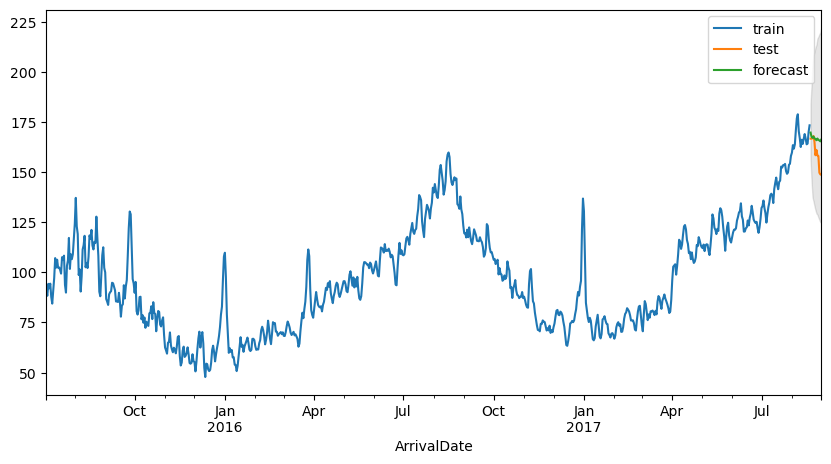

In [137]:
fig, ax = plt.subplots(figsize=(10,5))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
forecast_df['Forecast'].plot(ax=ax, label='forecast')
ax.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='k', alpha=0.1)
ax.legend();

# **Full Workflow**

---

**I will use a functionalized workflow from my prior time series modeling work to perform my analysis and generate my forecast.**
>
> This function:
>  * Splits the data at a threshold based on either a percentage or specific period (in this case, the past 90 days)
>  * Performs SARIMA modeling via PMD's Auto-Arima to determine the optimal hyperparameters and Statsmodels's SARIMAX model for the forecasting.
>  * Generates forecasted data and 95% confidence interval for the time period set in the train/test split step.
>  * Saves the train/test split data; forecast and confidence interval data; and associated visualizations to a dictionary for review.

---

In [ ]:
## Running the workflow
results = tsm.ts_modeling_workflow(ts_avg, threshold = -90, xlabel='Dates',
                                   ylabel = 'Cancellations (%)',
                                   title = 'Forecasted Cancellations', m=7,
                                   show_vis=False)

In [ ]:
## Inspecting the keys for the resulting dictionary
results.keys()

In [ ]:
##Rounding forecast data to nearest whole numbers
results['forecasted_data'] = (results['forecasted_data']*100).round(0)
results['forecasted_data']

In [ ]:
## Identifying average for the 90-day window
results['forecasted_data'].mean().round(0)

---

**Forecast Confidence Interval**

> Based on my time series model, the hotels may expect an average of 35% daily cancellations over the next 90 days. However, there is a confidence interval of  +/- 23.5%.
>
> **This large confidence interval limits the usefulness of the forecast due to the risk of errors.** If a hotel would overbook with the expectation of the average 35% cancellation rate, only to have a 45%+ cancellation rate, it would force the hotel to relocate a large number of reservations. As relocated reservations incur significant costs (both for paying for the relocated night as well as potentially losing future business), the risk of overbooking is too great with this model's forecast.

**Reducing Risk**

> The next step of this analysis would be adjusting the model to reduce variability of the forecast results. The adjustments may include:
 * Adding additional data (holidays, presence/absence of additional demand generators)
 * Adjusting threshold values for train/test split

**Looking Forward**

> My next steps will be to evaluate the impact of shorter- and longer-term thresholds for my training data. Initially, I started with a 90-day evaluation; I will reevaluate the performance using several different thresholds to compare the impact of using different windows for forecasting.

In [ ]:
## Testing new thresholds for train/test split and forecast

thresholds = [-3, -7, -15, -30, -60, -90, -180]

ints = {}

for threshold in thresholds:
    results = tsm.ts_modeling_workflow(ts_avg, threshold = threshold, xlabel='Dates',
                                       ylabel = 'Cancellations (%)',
                                       title = 'Forecasted Cancellations',
                                       m=7,show_vis=False)
    
    ints[threshold*-1] = [round(results['forecasted_data']['Lower CI'].mean(), 2)*100,
                  round(results['forecasted_data']['Forecast'].mean(), 2)*100,
                  round(results['forecasted_data']['Upper CI'].mean(), 2)*100]

In [ ]:
## Combining results into DataFrame for analysis and display

results_df = pd.DataFrame.from_dict(ints, orient = 'index')
results_df.rename(columns = {0: 'Lower CI', 1: 'Average', 2:'Upper CI'},
                 inplace=True)

results_df['CI Difference'] = (results_df['Upper CI'] - results_df['Lower CI'])

results_df.index.rename('Days Out', inplace=True)

results_df.style.background_gradient(subset = 'CI Difference', cmap='Reds')\
                                                            .format('{:.0f}%')

---

**Interval Impacts**

> Despite changing the threshold levels, there is little improvement in the confidence intervals.

---

# **Results and Recommendations**

## Results

---

**Best Performance:** 3/7/15 day windows
  * Guests are less likely to cancel based on prior classification modeling
  * Confidence intervals slightly smaller than longer-term perspective.
  
**Worst Performance:** 180+ days
  * Strongest likelihood of cancellations based on prior models
  * Limited benefits for on-site teams
    * Sales may use it for longer-term planning, such as business account performances or group booking trends
    * Operations may use it to identify potential spikes in occupancy/demand, guiding staffing decisions or intensive projects (such as deep cleaning, system updates, or renovations)
    
---

## Recommendations

**In my opinion, the best results came from using a 90-day threshold to forecast cancellations.**

> * **Short forecasts best for Operations:** creating schedules; ordering supplies; other time-sensitive decisions.
>  * *Limited benefit for Sales due to short window of opportunity to book groups or push business travel.*
>
>
> * **Longer Forecasts best for Sales:** booking groups and monitoring pickup; performing sales calls for targeted businesses.
>  * *Less beneficial for Operations - scheduling, purchasing supplies based on occupancy and demand.*

**Pros and Cons Based on Personal Experience/Opinions**

| Time Period (Days) | Pros | Cons | Best Use |
| --- | --- | --- | --- |
| 3, 7, 15 | Increased accuracy | Less reaction time | Operations-related decision making; scheduling |
| 30, 60, 90 | Actionable time window for Sales (group sales especially) | Less accurate; more of a "rough idea" | On-Site Sales & Marketing strategy |
| 180+ | Can identify problem areas; trends/events; and focus areas | Numbers can and will change based on bookings/cancellations | Long-term revenue management

---

## Caveats

---

***These results may not generalize well for other hotels and/or different times. They are meant to be guidelines and ideas for hotels to adapt to their needs.***

As mentioned in my prior classification modeling notebook, these results are specific to these two hotels for this given time period.

Each hotel is different: target clientele, amenities, locations, etc.. Additionally, larger market trends and unexpected events (locally or globally) may have positive and/or negative impacts on cancellations.

---

## Future Work

---

**Future work will include:**

* Multivariate time series modeling via variable autoregression (VAR)


* Specific breakdowns:
    * Guest type: transient, leisure, groups
    * Room type: several different room types
    * Hotel type: resort vs. city hotels


* Model deployment for hotel-specific results
---

# **Conclusion**

---

**Thank you for your interest in my work.**

This concludes my exploration of the hotel booking dataset via univariate time series analysis.

While the results are not as exact as I would prefer, I feel confident in their current state and look forward to performing additional analysis via multivariate time series modeling as well as model deployment.

**I welcome any comments or questions! Please feel free to contact me.**

---
